In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
 %cd "/content/drive/My Drive/Hand Written Text Recognition/IAM Folder"

/content/drive/My Drive/Hand Written Text Recognition/IAM Folder


In [3]:
!pip install stow
import stow
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 1.1 MB/s eta 0:00:00


In [8]:
dataset_path='iam_words'
dataset, vocab, max_len = [], set(), 0

# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(os.path.join("iam_words", "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if len(line_split) < 2:  # Check if line_split has at least two elements
        continue
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = line_split[0][:8]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

100%|██████████| 44583/44583 [01:18<00:00, 567.18it/s] 


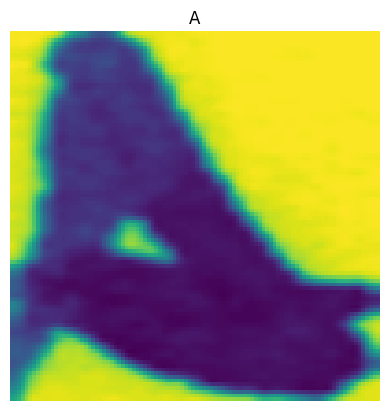

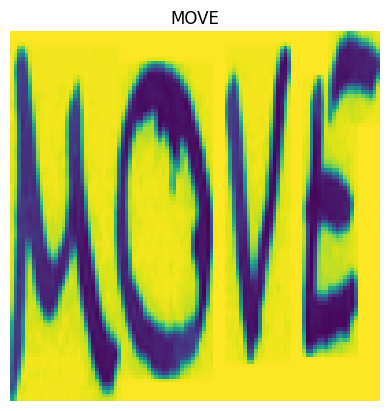

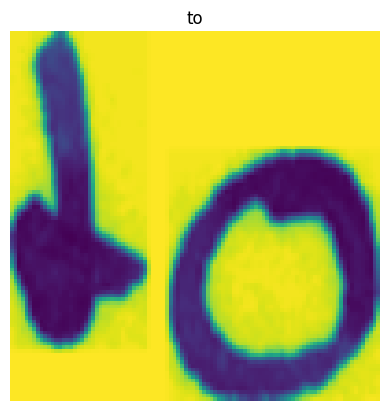

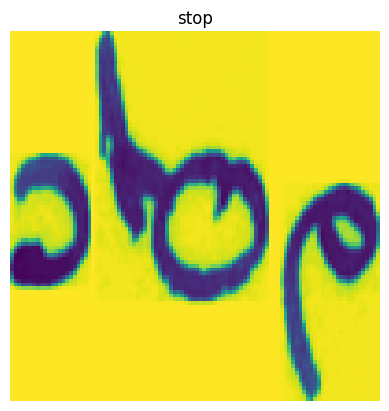

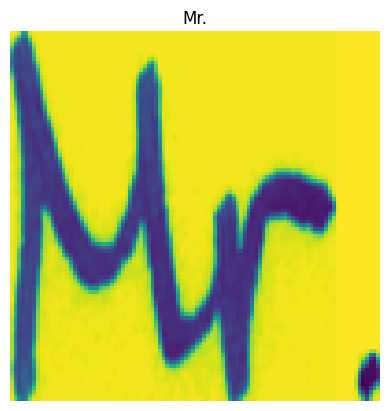

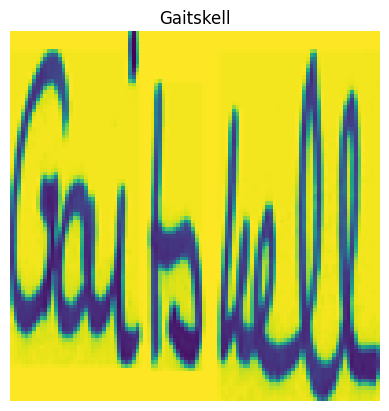

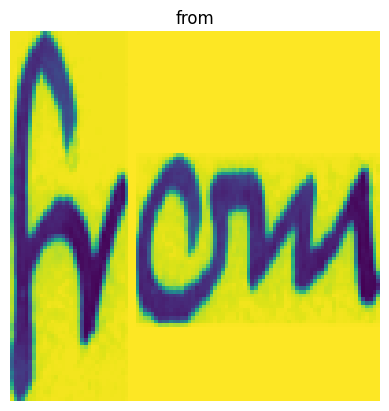

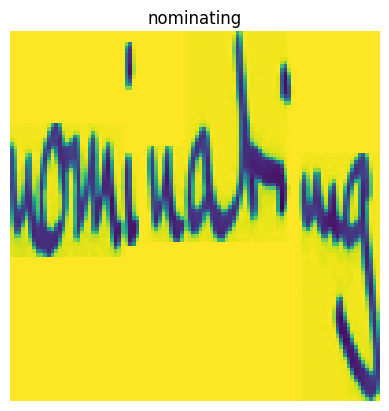

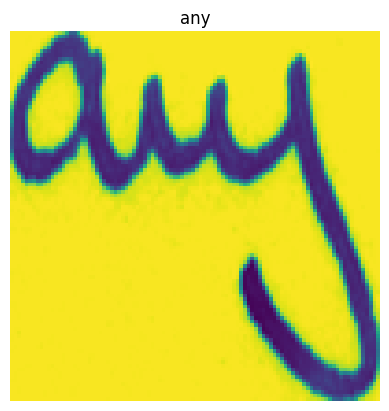

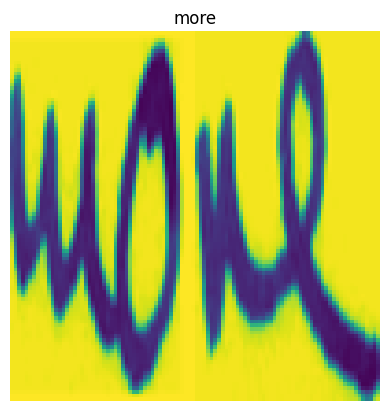

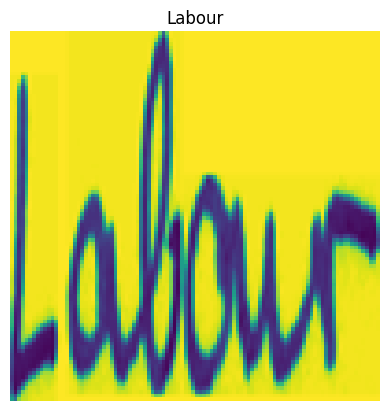

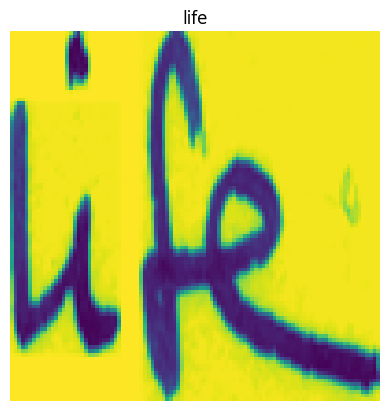

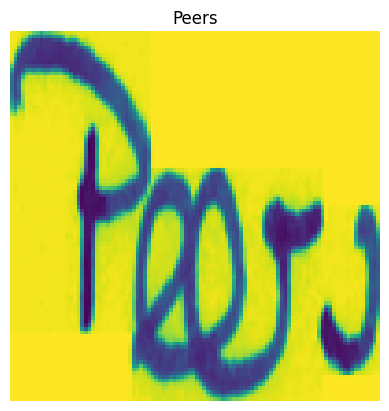

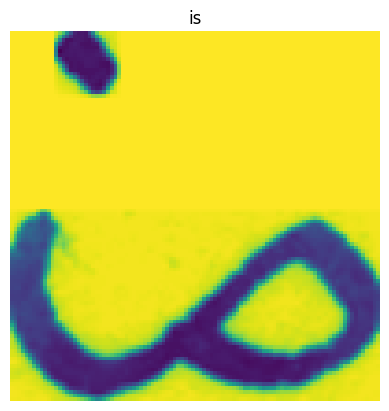

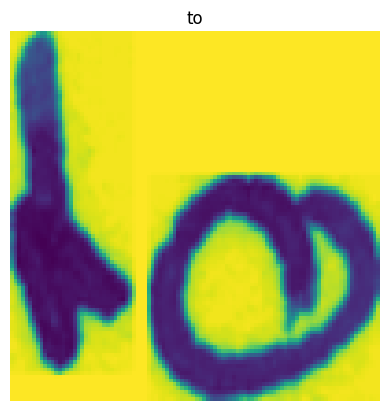

In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the size to which you want to resize the images
resize_width = 100  # Adjust this as needed
resize_height = 100  # Adjust this as needed

# Define the number of files you want to display
num_files_to_display = 15  # Adjust this as needed

# Iterate over a subset of the dataset
for file_path, label in dataset[:num_files_to_display]:
    # Load the image
    img = Image.open(file_path)

    # Resize the image
    img_resized = img.resize((resize_width, resize_height))

    # Display the resized image and its label
    plt.imshow(img_resized)
    plt.title(label)
    plt.axis('off')
    plt.show()


In [10]:
!pip install mltu
from mltu.configs import BaseModelConfigs
from datetime import datetime
class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Models/04_sentence_recognition", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 32
        self.learning_rate = 0.0005
        self.train_epochs = 1000
        self.train_workers = 20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.5 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6466 sha256=10f8efbf3cad46116c573e8f6427e8ffd93599a3e7855e8fe3748f161e9a8e09
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm


In [11]:
# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

In [12]:
from mltu.tensorflow.dataProvider import DataProvider
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

INFO:DataProvider:Skipping Dataset validation...


In [13]:
# model.py

from keras import layers
from keras.models import Model

from mltu.tensorflow.model_utils import residual_block


def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 128, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x9 = residual_block(x8, 128, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(blstm)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [14]:
# Creating TensorFlow model architecture
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CERMetric, WERMetric
import tensorflow as tf
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CTCloss(),
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
        ],
    run_eagerly=False
)
model.summary(line_length=110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input (InputLayer)              [(None, 96, 1408, 3)]            0          []                               
                                                                                                              
 lambda (Lambda)                 (None, 96, 1408, 3)              0          ['input[0][0]']                  
                                                                                                              
 conv2d (Conv2D)                 (None, 96, 1408, 32)             896        ['lambda[0][0]']                 
                                                                                                              
 batch_normalization (BatchNorm  (None, 96, 1408, 32)             128        ['conv2d[0][0]']    

In [15]:
!pip install tf2onnx
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 2.0 MB/s eta 0:00:00


In [ ]:
"""import numpy as np
x_train = np.array([sample[0] for sample in train_set])  # Input images
y_train = np.array([sample[1] for sample in train_set])  # Labels
x_val = np.array([sample[0] for sample in val_set])  # Validation images
y_val = np.array([sample[1] for sample in val_set])  # Validation labels
print("Shape of x_train_resized:", x_train.shape)
print("Shape of x_val_resized:", x_val.shape)
# Ensure input images have the correct shape
print("Shape of x_train:", x_train.shape)
print("Shape of x_val:", x_val.shape)"""


'import numpy as np\nx_train = np.array([sample[0] for sample in train_set])  # Input images\ny_train = np.array([sample[1] for sample in train_set])  # Labels\nx_val = np.array([sample[0] for sample in val_set])  # Validation images\ny_val = np.array([sample[1] for sample in val_set])  # Validation labels\nprint("Shape of x_train_resized:", x_train.shape)\nprint("Shape of x_val_resized:", x_val.shape)\n# Ensure input images have the correct shape\nprint("Shape of x_train:", x_train.shape)\nprint("Shape of x_val:", x_val.shape)'

In [ ]:
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)

# Save training and validation datasets as csv files
train_data_provider.to_csv(stow.join(configs.model_path, 'train.csv'))
val_data_provider.to_csv(stow.join(configs.model_path, 'val.csv'))

Epoch 1/1000
187/187 [==============================] - ETA: 0s - loss: 63.4778 - CER: 1.9286 - WER: 1.0000
Epoch 1: val_CER improved from inf to 1.00000, saving model to Models/04_sentence_recognition/202404301317/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/187 [==============================] - 316s 1s/step - loss: 63.4778 - CER: 1.9286 - WER: 1.0000 - val_loss: 16.3016 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 2/1000
187/187 [==============================] - ETA: 0s - loss: 16.5478 - CER: 1.0000 - WER: 1.0000
Epoch 2: val_CER did not improve from 1.00000
187/187 [==============================] - 221s 1s/step - loss: 16.5478 - CER: 1.0000 - WER: 1.0000 - val_loss: 15.9933 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 3/1000
187/187 [==============================] - ETA: 0s - loss: 16.1897 - CER: 1.0000 - WER: 1.0000
Epoch 3: val_CER did not improve from 1.00000
187/187 [==============================] - 221s 1s/step - loss: 16.1897 - CER: 1.0000 - WER: 1.0000 - val_loss: 16.0874 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 4/1000
187/187 [==============================] - ETA: 0s - loss: 15.8481 - CER: 1.0000 - WER: 1.0000
Epoch 4: val_CER did not improve from 1.00000
187/187 [==========

In [ ]:
import cv2
from PIL import Image
import numpy as np

def preprocess_images(image_paths, target_size=(100, 100), num_channels=3):
    images = []
    for path in image_paths:
        # Load and preprocess each image
        image = load_and_preprocess_image(path, target_size, num_channels)
        images.append(image)

    # Convert the list of images into a NumPy array
    return np.array(images)

def load_and_preprocess_image(image_path, target_size=(100, 100), num_channels=3):
    # Load the image from the given path
    image = Image.open(image_path)

    # Resize the image to the target size
    image = image.resize(target_size)

    # Convert the image to grayscale (if needed)
    image = image.convert('RGB') if num_channels == 3 else image.convert('L')

    # Normalize pixel values to the range [0, 1]
    image = np.array(image) / 255.0

    return image

# Usage example
x_train = np.array([sample[0] for sample in train_set])  # Input images
y_train = np.array([sample[1] for sample in train_set])  # Labels
x_val = np.array([sample[0] for sample in val_set])  # Validation images
y_val = np.array([sample[1] for sample in val_set])  # Validation labels

# Preprocess input images (e.g., resize, normalize pixel values)
x_train = preprocess_images(x_train)
x_val = preprocess_images(x_val)
"""target_shape = (1408, 96)
x_train_resized = np.array([cv2.resize(image, target_shape) for image in x_train])
x_val_resized = np.array([cv2.resize(image, target_shape) for image in x_val])"""

# Ensure input images have the correct shape
print("Shape of x_train_resized:", x_train.shape)
print("Shape of x_val_resized:", x_val.shape)
# Ensure input images have the correct shape
print("Shape of x_train:", x_train.shape)
print("Shape of x_val:", x_val.shape)





NameError: name 'train_set' is not defined

In [ ]:
# inferenceModel.py
import cv2
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from mltu.transformers import ImageResizer

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):
        image = ImageResizer.resize_maintaining_aspect_ratio(image, *self.input_shape[:2][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load("Models/04_sentence_recognition/202301131202/configs.yaml")

    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    df = pd.read_csv("Models/04_sentence_recognition/202301131202/val.csv").values.tolist()

    accum_cer, accum_wer = [], []
    for image_path, label in tqdm(df):
        image = cv2.imread(image_path)

        prediction_text = model.predict(image)

        cer = get_cer(prediction_text, label)
        wer = get_wer(prediction_text, label)
        print("Image: ", image_path)
        print("Label:", label)
        print("Prediction: ", prediction_text)
        print(f"CER: {cer}; WER: {wer}")

        accum_cer.append(cer)
        accum_wer.append(wer)

        cv2.imshow(prediction_text, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    print(f"Average CER: {np.average(accum_cer)}, Average WER: {np.average(accum_wer)}")

In [ ]:
# Train the model

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/mltu/tensorflow/losses.py", line 15, in __call__
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    ValueError: slice index 1 of dimension 0 out of bounds. for '{{node strided_slice_2}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](Shape_2, strided_slice_2/stack, strided_slice_2/stack_1, strided_slice_2/stack_2)' with input shapes: [1], [1], [1], [1] and with computed input tensors: input[1] = <1>, input[2] = <2>, input[3] = <1>.
